# DBSCAN - Density Based Spatial Clustering of Applications with Noise

In [15]:
import numpy as np 
import pandas as pd
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

%matplotlib inline

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [17]:
df = pd.DataFrame()
df = pd.read_csv('data/daft_apartments_with_features.csv')
df.head()

,Unnamed: 0,Region,Region_code,price_period,price_period_code,price,number_bathrooms,number_bedrooms,Parking,Central Heating,Washing Machine,Dryer,Dishwasher,Microwave,Pets Allowed,Wheelchair Access,Garden / Patio / Balcony,Serviced Property
0,0,Dublin 2,8,month,0,2970,2,2,1,1,1,1,1,1,1,1,1,1
1,1,Dublin 2,8,month,0,3690,2,3,1,1,1,1,1,1,1,1,1,1
2,2,Dublin 2,8,month,0,4000,2,2,1,1,1,1,1,1,1,1,1,1
3,3,Dublin 1,0,month,0,2300,1,1,1,1,1,1,1,1,1,1,1,0
4,4,Dublin 1,0,month,0,2430,1,1,1,1,1,1,1,1,1,1,1,0


In [66]:
# drop column 'Unnamed: 0'
df.drop(['Unnamed: 0'], axis = 1, inplace=True)
df = df.reset_index(drop=True)


In [67]:
df.columns

Index(['Region', 'Region_code', 'price_period', 'price_period_code', 'price',
       'number_bathrooms', 'number_bedrooms', 'Parking', 'Central Heating',
       'Washing Machine', 'Dryer', 'Dishwasher', 'Microwave', 'Pets Allowed',
       'Wheelchair Access', 'Garden / Patio / Balcony', 'Serviced Property'],
      dtype='object')

In [68]:
# selected_columns = ['Region_code', 'price_period_code', 'price',
#        'number_bathrooms', 'number_bedrooms', 'Parking', 'Central Heating',
#        'Washing Machine', 'Dryer', 'Dishwasher', 'Microwave', 'Pets Allowed',
#        'Wheelchair Access', 'Garden / Patio / Balcony', 'Serviced Property']

# eps=2, min_samples=10
# selected_columns = ['Region_code', 'number_bathrooms', 'number_bedrooms', 
#        'Washing Machine', 'Dryer', 'Dishwasher']

# eps=2, min_samples=10
selected_columns = ['Region_code', 'Washing Machine', 'Dryer', 'Dishwasher']

df_data_array = StandardScaler().fit_transform(df[selected_columns])

# Compute DBSCAN
db = DBSCAN(eps=2, min_samples=10).fit(df_data_array)

labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_data_array, labels))


Estimated number of clusters: 6
Estimated number of noise points: 3
Silhouette Coefficient: 0.539


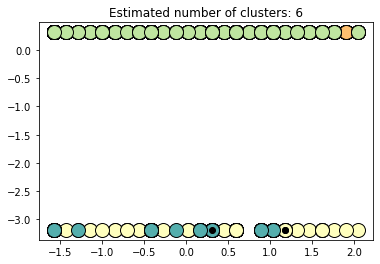

In [73]:
# Plot result
import matplotlib.pyplot as plt

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_data_array[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = df_data_array[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_ )
plt.show()

In [74]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)
    
    n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in labels else 0)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}, Estimated number of clusters={}".format(dbscan.eps, dbscan.min_samples, n_clusters_), fontsize=14)

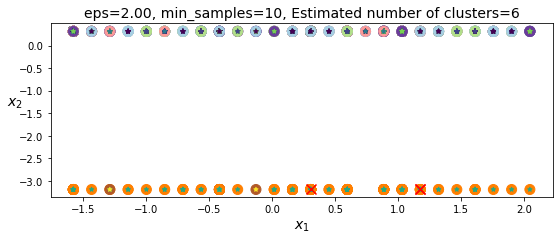

In [77]:
plt.figure(figsize=(9, 3.2))

plot_dbscan(db, df_data_array, size=100, show_ylabels=True)

# save_fig("dbscan_plot")
plt.show()